### model check_point 불러오기

In [1]:
model_checkpoint = "nvidia/mit-b0"  # pre-trained model from which to fine-tune


Before we start, let's install the `datasets`, `transformers`, and `evaluate` libraries. We also install Git-LFS to upload the model checkpoints to Hub.



In [2]:
# !pip -q install datasets transformers evaluate

# !git lfs install
# !git config --global credential.helper store

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


In [4]:
from huggingface_hub import notebook_login

notebook_login()

### Loading the dataset

In [5]:
# from PIL import Image, ImageDraw
# import os
# import json

# # 데이터셋 위치
# dataset_path = "C:\\jupyter\\Externel_activity\\Selfdrive_segmentation\\data\\2DSS"
# # 라벨별 색 지정

# class_colors = {
#     'road': 1,
#     'sidewalk': 2,
#     'road roughness': 3,
#     'road boundaries': 4,
#     'crosswalks': 5,
#     'lane': 6,
#     'road color guide': 7,
#     'road marking': 8,
#     'parking': 9,
#     'traffic sign': 10,
#     'traffic light': 11,
#     'pole/structural object': 12,
#     'building': 13,
#     'tunnel': 14,
#     'bridge': 15,
#     'pedestrian': 16,
#     'vehicle': 17,
#     'bicycle': 18,
#     'motorcycle': 19,
#     'personal mobility': 20,
#     'dynamic': 21,
#     'vegetation': 22,
#     'sky': 23,
#     'static': 24
# }

# def create_label_image(data, image_size):
#     """다각형 데이터를 사용하여 라벨 이미지를 생성하는 함수"""
#     image = Image.new("L", tuple(image_size), 255)  # 2차원 이미지 (L 모드)로 생성
#     draw = ImageDraw.Draw(image)

#     # instance id 기준으로 Annotation 리스트 정렬 (낮은 값이 우선)
#     annotations = sorted(data['Annotation'], key=lambda x: x['instance_id'])

#     for annotation in annotations:
#         class_name = annotation['class_name']
#         color = class_colors.get(class_name, 0)  # 해당 클래스의 회색조 값 가져오기, 기본은 0 (검정색)
#         points = annotation['data'][0]  # 다각형의 점 좌표
#         polygon = [(points[i], points[i + 1]) for i in range(0, len(points), 2)]
#         draw.polygon(polygon, outline=None, fill=color)  # 외곽선 없이 채우기 색상만 지정

#     return image

# def process_case(case_path):
#     """각 케이스의 이미지와 라벨을 처리하는 함수"""
#     label_path = os.path.join(case_path, 'labels')
#     save_path = os.path.join(case_path, 'gray_label_images')

#     if not os.path.isdir(save_path):
#         os.makedirs(save_path)

#     print(label_path)
#     label_files = os.listdir(label_path)

#     for json_name in label_files:
#         json_file_path = os.path.join(label_path, json_name)
#         with open(json_file_path, 'r') as file:
#             data = json.load(file)
#             image_size = data['image_size']
#             label_image = create_label_image(data, image_size)
#             label_image.save(os.path.join(save_path, json_name.replace('.json', '.png')))

# def main(dataset_path):
#     """데이터셋 경로에서 모든 케이스를 처리하는 메인 함수"""
#     for case in os.listdir(dataset_path):
#         case_path = os.path.join(dataset_path, case)
#         if os.path.isdir(case_path):  # validation / test / train
#             process_case(case_path)

# if __name__ == "__main__":
#     main(dataset_path) 


In [6]:
import os
from PIL import Image
from datasets import Dataset, DatasetDict

def create_segmentation_dataset(train_dir, label_dir):
    image_files = sorted([f for f in os.listdir(train_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
    label_files = sorted([f for f in os.listdir(label_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])

    pixel_values = []
    labels = []

    for img_file, label_file in zip(image_files, label_files):
        # 이미지 로드
        img_path = os.path.join(train_dir, img_file)
        img = Image.open(img_path)
        pixel_values.append(img)

        # 레이블 이미지 로드
        label_path = os.path.join(label_dir, label_file)
        label = Image.open(label_path).convert('L')  # 그레이스케일로 변환
        labels.append(label)

    dataset = Dataset.from_dict({
        "pixel_values": pixel_values,
        "label": labels
    })

    return DatasetDict({"train": dataset})

# 데이터셋 생성
train_dir = "C:\\jupyter\\Externel_activity\\Selfdrive_segmentation\\data\\small\\training\\images"
label_dir = "C:\\jupyter\\Externel_activity\\Selfdrive_segmentation\\data\\small\\training\\label_images"
dataset_dict = create_segmentation_dataset(train_dir, label_dir)

print(dataset_dict)

# 첫 번째 항목 출력
first_item = dataset_dict['train'][0]
print(f"First item: {first_item}")
print(f"Image mode and size: {first_item['pixel_values'].mode}, {first_item['pixel_values'].size}")
print(f"Label mode and size: {first_item['label'].mode}, {first_item['label'].size}")

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 180
    })
})
First item: {'pixel_values': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x1200 at 0x11ED86962C8>, 'label': <PIL.PngImagePlugin.PngImageFile image mode=L size=1920x1200 at 0x11ED8696808>}
Image mode and size: RGB, (1920, 1200)
Label mode and size: L, (1920, 1200)


### 데이터 세트 만들기

학습 데이터 만들기

In [7]:
# # 자신의 폴더 경로에 맞게 재지정해주세요.
# import os
# root_path = 'C:\\jupyter\\Externel_activity\\Selfdrive_segmentation\\data\\2DSS\\'

# data_dir = root_path

# # data_dir의 경로(문자열)와 train(문자열)을 결합해서 train_dir(train 폴더의 경로)에 저장합니다.
# train_dir = os.path.join(data_dir, "training\\images")

# # data_dir의 경로(문자열)와 val(문자열)을 결합해서 val_dir(val 폴더의 경로)에 저장합니다.
# val_dir = os.path.join(data_dir, "validation\\images")

# # train_dir 경로에 있는 모든 파일을 리스트의 형태로 불러와서 train_fns에 저장합니다.
# train_fns = os.listdir(train_dir)

# # val_dir 경로에 있는 모든 파일을 리스트의 형태로 불러와서 val_fns에 저장합니다.
# val_fns = os.listdir(val_dir)

# print(len(train_fns), len(val_fns))

### 데이터 셋 정의하기

In [8]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 180
    })
})

Let us also load the Mean IoU metric, which we'll use to evaluate our model both during and after training.

IoU (short for Intersection over Union) tells us the amount of overlap between two sets. In our case, these sets will be the ground-truth segmentation map and the predicted segmentation map. To learn more, you can check out [this article](https://learnopencv.com/intersection-over-union-iou-in-object-detection-and-segmentation/).

In [9]:
import evaluate

metric = evaluate.load("mean_iou")

The `ds` object itself is a `DatasetDict`, which contains one key per split (in this case, only "train" for a training split).

Here, the `features` tell us what each example is consisted of:

* `pixel_values`: the actual image
* `label`: segmentation mask



To access an actual element, you need to select a split first, then give an index:

In [10]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 180
    })
})

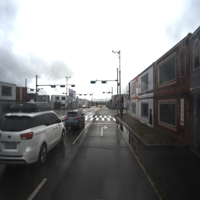

In [11]:
example2=dataset_dict['train'][0]
example2["pixel_values"].resize((200, 200))

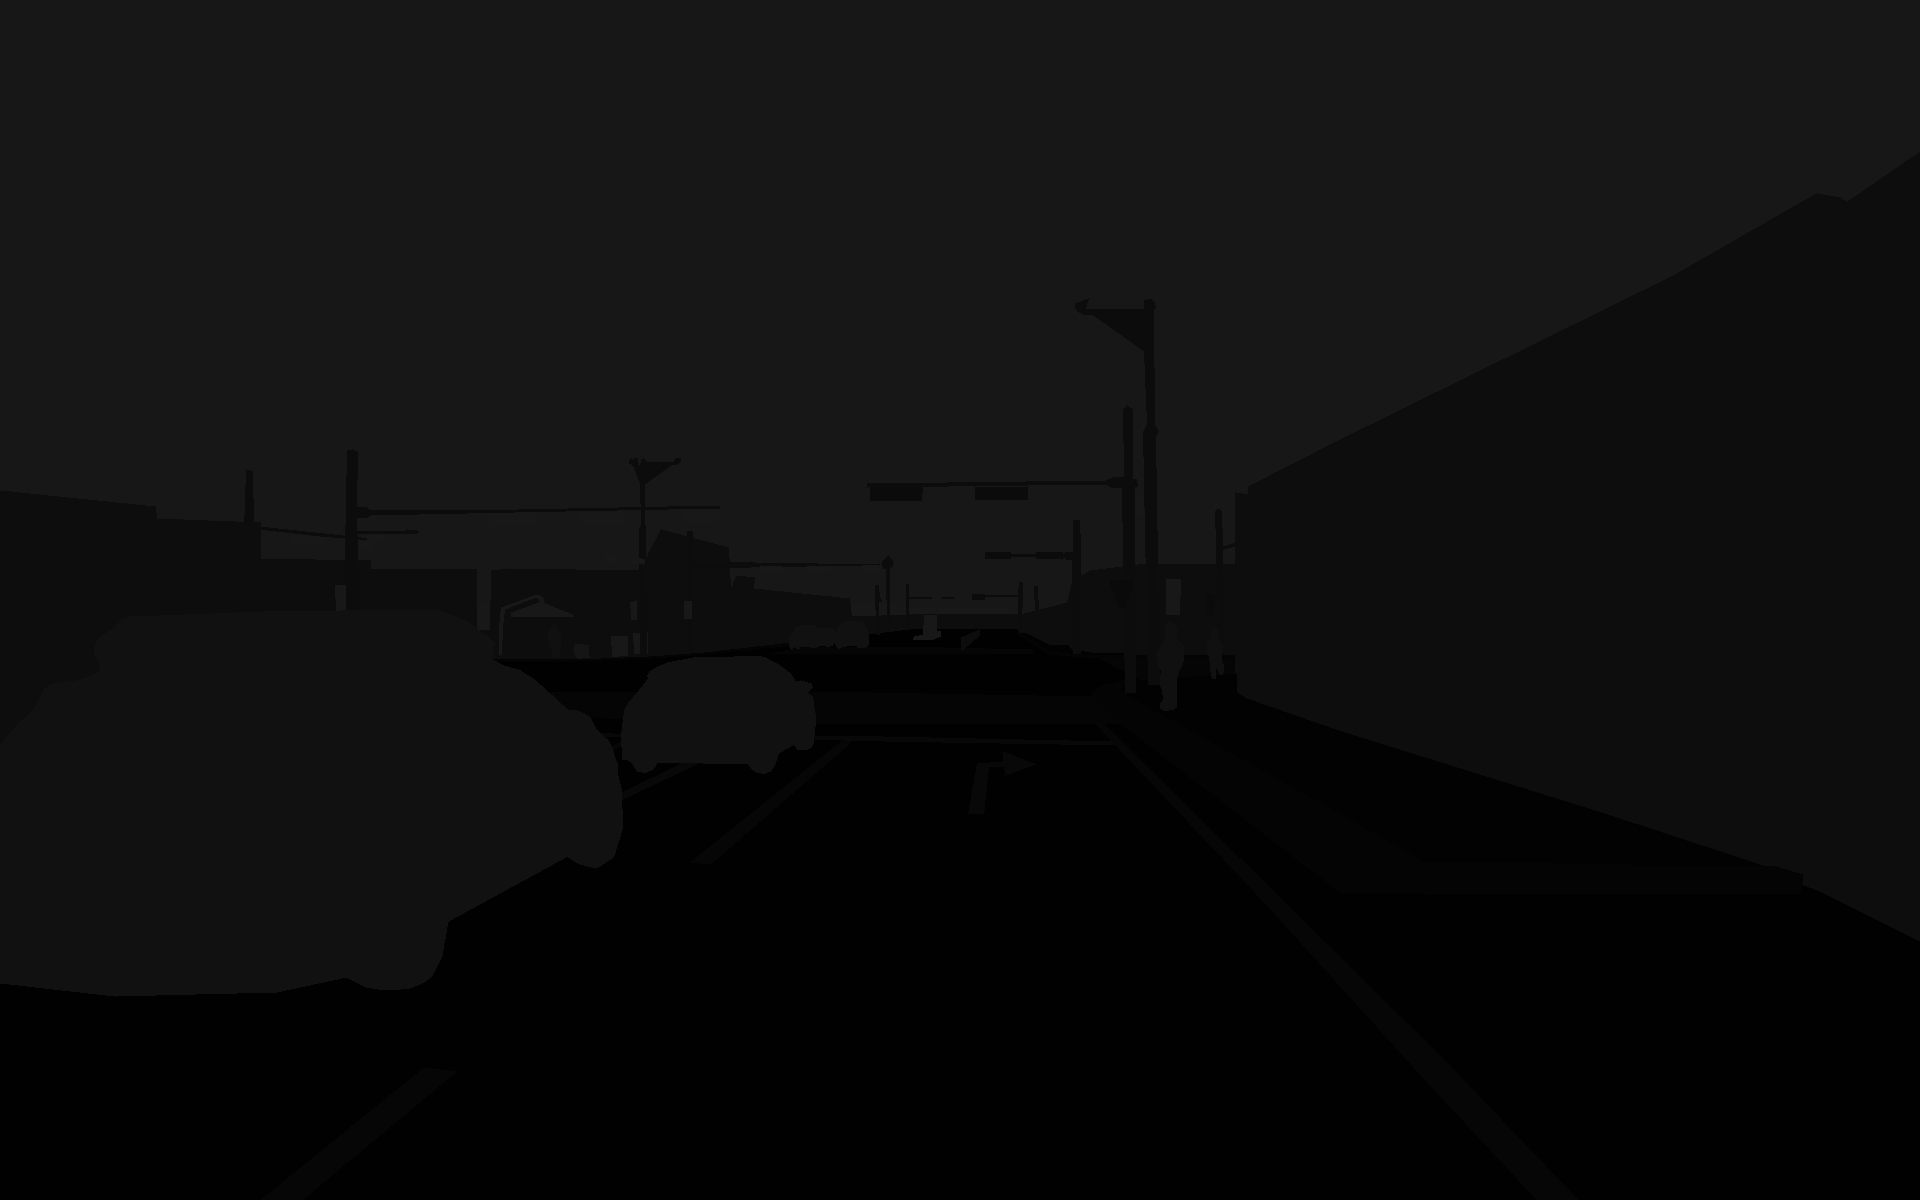

In [12]:
example2["label"]

Each of the pixels above can be associated to a particular category. Let's load all the categories that are associated with the dataset. Let's also create an `id2label` dictionary to decode them back to strings and see what they are. The inverse `label2id` will be useful too, when we load the model later.

In [13]:
import json

# 파일 경로 설정
file_path = "C:\\jupyter\\Externel_activity\\Selfdrive_segmentation\\data\\2DSS\\training\\labels\\E_DCG_230829_141_FC_008.json"

# JSON 파일 읽기
with open(file_path, 'r') as file:
    data = json.load(file)

In [14]:
class_names = set()
for annotation in data['Annotation']:
    class_names.add(annotation['class_name'])

# 클래스 이름에 ID 할당
id2label = {i: name for i, name in enumerate(sorted(class_names))}
# 클래스 이름에 ID 할당
label2id = {name: i for i, name in enumerate(sorted(class_names))}

# # 'unlabeled' 클래스를 0으로 추가
label2id = {'unlabeled': 0, **{k: v+1 for k, v in label2id.items()}}
id2label = {0: 'unlabeled', **{k+1: v for k, v in id2label.items()}}



In [15]:
label2id

{'unlabeled': 0,
 'building': 1,
 'crosswalks': 2,
 'dynamic': 3,
 'lane': 4,
 'pedestrian': 5,
 'pole/structural object': 6,
 'road': 7,
 'road boundaries': 8,
 'road marking': 9,
 'sidewalk': 10,
 'sky': 11,
 'static': 12,
 'traffic light': 13,
 'traffic sign': 14,
 'vehicle': 15}

In [16]:
id2label

{0: 'unlabeled',
 1: 'building',
 2: 'crosswalks',
 3: 'dynamic',
 4: 'lane',
 5: 'pedestrian',
 6: 'pole/structural object',
 7: 'road',
 8: 'road boundaries',
 9: 'road marking',
 10: 'sidewalk',
 11: 'sky',
 12: 'static',
 13: 'traffic light',
 14: 'traffic sign',
 15: 'vehicle'}

In [17]:
num_labels = len(id2label)

**Note**: This dataset specificaly sets the 0th index as being `unlabeled`. We want to take this information into consideration while computing the loss. Specifically, we'll want to mask the pixels where the network predicted `unlabeled` and avoid computing the loss for it since it doesn't contribute to to training that much.

Let's shuffle the dataset and split the dataset in a train and test set. We'll explicitly define a random seed to use when calling `ds.shuffle()` to ensure our results are the same each time we run this cell.

In [18]:
dataset_dict = dataset_dict.shuffle(seed=1)
dataset_dict = dataset_dict["train"].train_test_split(test_size=0.2)
train_ds = dataset_dict["train"]
test_ds = dataset_dict["test"]

### Preprocessing the data

Before we can feed these images to our model, we need to preprocess them.

Preprocessing images typically comes down to (1) resizing them to a particular size (2) normalizing the color channels (R,G,B) using a mean and standard deviation. These are referred to as **image transformations**.

To make sure we (1) resize to the appropriate size (2) use the appropriate image mean and standard deviation for the model architecture we are going to use, we instantiate what is called a feature extractor with the `AutoFeatureExtractor.from_pretrained` method.

This feature extractor is a minimal preprocessor that can be used to prepare images for model training and inference.

In [19]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint, do_reduce_labels=True)
feature_extractor

c:\Users\jaemin\Anaconda3\envs\langu\lib\site-packages\transformers\models\segformer\feature_extraction_segformer.py:31: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  FutureWarning,
c:\Users\jaemin\Anaconda3\envs\langu\lib\site-packages\transformers\models\segformer\image_processing_segformer.py:102: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  FutureWarning,


SegformerFeatureExtractor {
  "do_normalize": true,
  "do_reduce_labels": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "SegformerFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "SegformerFeatureExtractor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 512,
    "width": 512
  }
}

In [20]:
from torchvision.transforms import ColorJitter
from transformers import SegformerFeatureExtractor

feature_extractor = SegformerFeatureExtractor()
jitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1)

def train_transforms(example_batch):
    images = [jitter(x) for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = feature_extractor(images, labels)
    return inputs


def val_transforms(example_batch):
    images = [x for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = feature_extractor(images, labels)
    return inputs


# Set transforms
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

# from torchvision.transforms import ColorJitter
# from transformers import SegformerFeatureExtractor
# import numpy as np

# feature_extractor = SegformerFeatureExtractor()
# jitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1)

# def train_transforms(example_batch):
#     images = [jitter(x) for x in example_batch['pixel_values']]
#     labels = [np.squeeze(x) for x in example_batch['label']]  # Remove the last dimension
#     inputs = feature_extractor(images, labels, return_tensors="pt")
#     return inputs

# def val_transforms(example_batch):
#     images = [x for x in example_batch['pixel_values']]
#     labels = [np.squeeze(x) for x in example_batch['label']]  # Remove the last dimension
#     inputs = feature_extractor(images, labels, return_tensors="pt")
#     return inputs

# # Set transforms
# train_ds.set_transform(train_transforms)
# test_ds.set_transform(val_transforms)

In [21]:
train_ds

Dataset({
    features: ['pixel_values', 'label'],
    num_rows: 144
})

### Training the model

Now that our data is ready, we can download the pretrained model and fine-tune it. We will use the `SegformerForSemanticSegmentation` class. Calling the `from_pretrained` method on it will download and cache the weights for us. As the label ids and the number of labels are dataset dependent, we pass `label2id`, and `id2label` alongside the `model_checkpoint` here. This will make sure a custom segmentation head is created (with a custom number of output neurons).

In [22]:
num_labels

16

In [23]:
from transformers import SegformerForSemanticSegmentation


model = SegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,  # Will ensure the segmentation specific components are reinitialized.
)



Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.1.proj.weight', 'decode_head.classifier.bias', 'decode_head.linea

In [24]:
from transformers import TrainingArguments

epochs = 100
lr = 0.00006
batch_size = 2

hub_model_id = "segformer-b0-finetuned-segments-sidewalk-2"

training_args = TrainingArguments(
    "segformer-b0-finetuned-segments-sidewalk-outputs",
    learning_rate=lr,

    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_total_limit=3,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=20,
    eval_steps=20,
    logging_steps=1,
    eval_accumulation_steps=5,
    load_best_model_at_end=True,
    push_to_hub=True,
    hub_model_id=hub_model_id,
    hub_strategy="end",
)

Next, we'll define a function that computes the evaluation metric we want to work with. Because we're doing semantic segmentation, we'll use the [mean Intersection over Union (mIoU)](https://huggingface.co/spaces/evaluate-metric/mean_iou), which is directly accessible in the [`evaluate` library](https://huggingface.co/docs/evaluate/index). IoU represents the overlap of segmentation masks. Mean IoU is the average of the IoU of all semantic classes. Take a look at [this blogpost](https://www.jeremyjordan.me/evaluating-image-segmentation-models/) for an overview of evaluation metrics for image segmentation.

Because our model outputs logits with dimensions height/4 and width/4, we have to upscale them before we can compute the mIoU.

In [25]:
import torch
from torch import nn
import evaluate

metric = evaluate.load("mean_iou")

def compute_metrics(eval_pred):
  with torch.no_grad():
    logits, labels = eval_pred
    logits_tensor = torch.from_numpy(logits)
    # scale the logits to the size of the label
    logits_tensor = nn.functional.interpolate(
        logits_tensor,
        size=labels.shape[-2:],
        mode="bilinear",
        align_corners=False,
    ).argmax(dim=1)

    pred_labels = logits_tensor.detach().cpu().numpy()
    # currently using _compute instead of compute
    # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
    metrics = metric._compute(
            predictions=pred_labels,
            references=labels,
            num_labels=len(id2label),
            ignore_index=0,
            reduce_labels=feature_extractor.do_reduce_labels,
        )

    # add per category metrics as individual key-value pairs
    per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
    per_category_iou = metrics.pop("per_category_iou").tolist()

    metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
    metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

    return metrics


Finally, we can instantiate a `Trainer` object.



In [26]:
from transformers import Trainer
from transformers import default_data_collator
trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer=feature_extractor,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics
)


CalledProcessError: Command '['git-lfs', '--version']' returned non-zero exit status 1.

Notice that we're passing `feature_extractor` to the `Trainer`. This will ensure the feature extractor is also uploaded to the Hub along with the model checkpoints.

Now that our trainer is set up, training is as simple as calling the train function. We don't need to worry about managing our GPU(s), the trainer will take care of that.

In [ ]:
!pip install hf-lfs

In [ ]:
!git config --global user.email "<my_github_jmjung1997@naver.com>"
!git config --global user.name "<my_github_jmjung1997>"

In [ ]:
trainer.train()

When we're done with training, we can push our fine-tuned model to the Hub.

This will also automatically create a model card with our results. We'll supply some extra information in kwargs to make the model card more complete.

In [ ]:
x = torch.rand((4, 6, 320, 480))
new_x = x.permute((0,2,3,1)).squeeze()

In [ ]:
x.shape[0:-1]

In [ ]:
new_x.shape

In [ ]:
new_x2.shape

In [ ]:
pretrained_model_name='jm'
hf_dataset_identifier = "segments/sidewalk-semantic"
# kwargs = {
#     "tags": ["vision", "image-segmentation"],
#     "finetuned_from": pretrained_model_name,
#     "dataset": hf_dataset_identifier,
# }

kwargs = {
    "tags": ["vision", "image-segmentation"]
    
}

trainer.push_to_hub(**kwargs)

## Inference

Now comes the exciting part -- using our fine-tuned model! In this section, we'll show how you can load your model from the hub and use it for inference.

However, you can also try out your model directly on the Hugging Face Hub, thanks to the cool widgets powered by the [hosted inference API](https://api-inference.huggingface.co/docs/python/html/index.html). If you pushed your model to the Hub in the previous step, you should see an inference widget on your model page. You can add default examples to the widget by defining example image URLs in your model card. See [this model card](https://huggingface.co/segments-tobias/segformer-b0-finetuned-segments-sidewalk/blob/main/README.md) as an example.

<figure class="image table text-center m-0 w-full">
    <video
        alt="The interactive widget of the model"
        style="max-width: 70%; margin: auto;"
        autoplay loop autobuffer muted playsinline
    >
      <source src="assets/56_fine_tune_segformer/widget.mp4" poster="assets/56_fine_tune_segformer/widget-poster.png" type="video/mp4">
  </video>
</figure>

### Use the model from the Hub

We'll first load the model from the Hub using `SegformerForSemanticSegmentation.from_pretrained()`.

In [ ]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation

feature_extractor = SegformerFeatureExtractor.from_pretrained(model_checkpoint)
hf_username = "jaemin12"
model = SegformerForSemanticSegmentation.from_pretrained(f"{hf_username}/{hub_model_id}")

Next, we'll load an image from our test dataset and its associated ground truth segmentation label.

In [ ]:
image = test_ds[0]['pixel_values']
gt_seg = test_ds[0]['labels']
image

To segment this test image, we first need to prepare the image using the feature extractor. Then we'll forward it through the model.

We also need to remember to upscale the output logits to the original image size. In order to get the actual category predictions, we just have to apply an `argmax` on the logits.

In [ ]:
import numpy as np
from PIL import Image
image = ((image + 1.0) * 255/2).astype(np.uint8)
image = Image.fromarray((image.transpose(1, 2, 0) * 255).astype(np.uint8))

In [ ]:
from torch import nn

inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)

# First, rescale logits to original image size
upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1], # (height, width)
    mode='bilinear',
    align_corners=False
)

# Second, apply argmax on the class dimension
pred_seg = upsampled_logits.argmax(dim=1)[0]
#image = np.array(image).transpose(2, 0, 1)

Now it's time to display the result. The next cell defines the colors for each category, so that they match the "category coloring" on Segments.ai.

In [ ]:
def sidewalk_palette():
    """Sidewalk palette that maps each class to RGB values."""
    return [
        [135, 206, 235],  # Light Blue
        [128, 128, 128],  # Gray (static)
        [169, 169, 169],  # Dark Gray (road)
        [139, 69, 19],    # Brown (pole/structural object)
        [34, 139, 34],    # Green (vegetation)
        [255, 165, 0],    # Orange (building)
        [255, 255, 0],    # Yellow (sidewalk)
        [255, 0, 0],      # Red (road boundaries)
        [0, 0, 255],      # Blue (pedestrian)
        [128, 0, 128],    # Purple (vehicle)
        [255, 69, 0],     # Red-Orange (traffic light)
        [255, 255, 255],  # White (crosswalks)
        [255, 20, 147],   # Pink (lane)
        [0, 255, 255],    # Cyan (traffic sign)
        [0, 0, 0],        # Black (dynamic)
        [160, 82, 45],    # Sienna (road roughness)
        [255, 192, 203],  # Light Pink (road color guide)
        [218, 112, 214],  # Orchid (road marking)
        [70, 130, 180],   # Steel Blue (parking)
        [46, 139, 87],    # Sea Green (tunnel)
        [205, 133, 63],   # Peru (bridge)
        [106, 90, 205],   # Slate Blue (bicycle)
        [255, 140, 0],    # Dark Orange (motorcycle)
        [72, 61, 139]     # Dark Slate Blue (personal mobility)
    ]

The next function overlays the output segmentation map on the original image.

In [ ]:
import numpy as np

def get_seg_overlay(image, seg):
  color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
  palette = np.array(sidewalk_palette())
  for label, color in enumerate(palette):
      color_seg[seg == label, :] = color

  # Show image + mask
  img = np.array(image) * 0.5 + color_seg * 0.5
  img = img.astype(np.uint8)

  return img

We'll display the result next to the ground-truth mask.

In [ ]:
import matplotlib.pyplot as plt

pred_img = get_seg_overlay(image, pred_seg)
gt_img = get_seg_overlay(image, np.array(gt_seg))

f, axs = plt.subplots(1, 2)
f.set_figheight(30)
f.set_figwidth(50)

axs[0].set_title("Prediction", {'fontsize': 40})
axs[0].imshow(pred_img)
axs[1].set_title("Ground truth", {'fontsize': 40})
axs[1].imshow(gt_img)

What do you think? Would you send our pizza delivery robot on the road with this segmentation information?

The result might not be perfect yet, but we can always expand our dataset to make the model more robust. We can now also go train a larger SegFormer model, and see how it stacks up. If you want to explore further beyond this notebook, here are some things you can try next:

* Train the model for longer.
* Try out the different segmentation-specific training augmentations from libraries like [`albumentations`](https://albumentations.ai/docs/getting_started/mask_augmentation/).
* Try out a larger variant of the SegFormer model family or try an entirely new model family like MobileViT.